Initial Entropy:  0.9999999999999993
Action:  right (0, 0) : Information Gain = 0.08170416594551044
I turned  right  and my environment is
[[  0 100]]
Action:  forward (0, 1) : Information Gain = 0.08170416594551044
I turned  forward  and my environment is
[[  0 100]]
Action:  left (0, 1) : Information Gain = 0.08170416594551044
I turned  left  and my environment is
[[  0 100]
 [  1   1]]
Action:  forward (1, 1) : Information Gain = 0.014771863965748477
I turned  forward  and my environment is
[[  0 100]
 [  1   1]]
Action:  right (1, 1) : Information Gain = 0.08170416594551044
I turned  right  and my environment is
[[  0   1 100]
 [  1   1   1]]
Action:  forward (1, 2) : Information Gain = 0.029049405545331308
I turned  forward  and my environment is
[[  0   1 100]
 [  1   1   1]]
Action:  left (1, 2) : Information Gain = 0.10950835978050866
I turned  left  and my environment is
[[  0   1 100]
 [  1   1   1]
 [  1   1   1]]
Action:  forward (2, 2) : Information Gain = 0.05971404132936

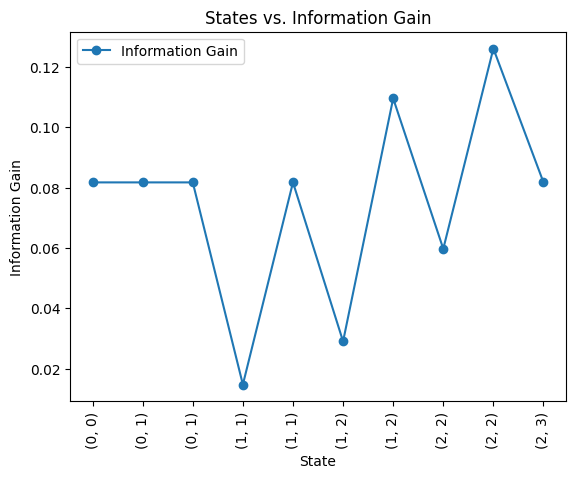

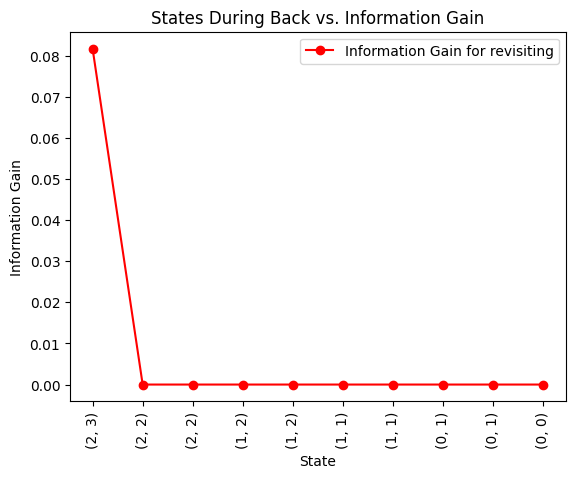

In [20]:
#!/usr/bin/env python3
import ipdb
import time
import matplotlib.pyplot as plt
import spacy
import numpy as np
from collections import deque
import rclpy
from rclpy.node import Node
from geometry_msgs.msg import Twist

# Class to derive the current direction of the mobile robot
class Robot:
  def __init__(self, x=0, y=0, orientation='N'):
    self.x = x
    self.y = y
    self.orientation = orientation
  def get_position(self):
    return self.x, self.y
  def get_orientation(self):
    return self.orientation
  def turn_left(self):
    if self.orientation == "N":
      self.orientation = "W"
    elif self.orientation == "W":
      self.orientation = "S"
    elif self.orientation == "S":
      self.orientation = "E"
    elif self.orientation == "E":
      self.orientation = "N"
  def turn_right(self):
    if self.orientation == "N":
      self.orientation = "E"
    elif self.orientation == "E":
      self.orientation = "S"
    elif self.orientation == "S":
      self.orientation = "W"
    elif self.orientation == "W":
      self.orientation = "N"

# Instantiate
my_robot = Robot()

# Class to control the movement of the mobile robot
class TurtlebotController(Node):
  def __init__(self, node_name):
    super().__init__(node_name)
    self.velocity_publisher = self.create_publisher(Twist, '/cmd_vel', 10)
    self.start_time = None
    self.is_forward_complete = False
    self.cmd_vel = Twist()
    self.cmd_vel.linear.x = 0.0
    self.cmd_vel.angular.z = 0.0
  def move_forward(self):
    self.cmd_vel.linear.x = 1.0
    self.cmd_vel.angular.z = 0.0
    self.velocity_publisher.publish(self.cmd_vel)
    print("Moving Forward")
    time.sleep(10)
  def turn_left(self):
    self.cmd_vel.linear.x = 0.0
    self.cmd_vel.angular.z = 1.3
    self.velocity_publisher.publish(self.cmd_vel)
    print("Turning left")
    time.sleep(10)
  def turn_right(self):
    self.cmd_vel.linear.x = 0.0
    self.cmd_vel.angular.z = -3.0
    self.velocity_publisher.publish(self.cmd_vel)
    print("Turning Right")
    time.sleep(10)

rclpy.init()
node_name = 'turtlebot_controller'
controller = TurtlebotController(node_name=node_name)

nlp = spacy.load("en_core_web_sm")      # Load english library to the NLP engine
# sentence = "Turtlebot is ready to start from Indiana. Turn right and go forward. Then turn right and go forward. Turn left and go forward. You will reach your destination, Chicago. Pick up the object and travel back to your origin"
sentence = "Turtlebot is ready to start from Indiana. Turn right and go forward. Then turn left and go forward. Turn right and go forward. Turn left and go forward. Turn right and go forward.You will reach your destination, Chicago. Come back to your origin"
doc = nlp(sentence)

states = []              # Captue the Start and End state
actions = []             # Array to store the actions filtered from the sentence
                         # Define a set of possible actions
posssible_actions = ['forward', 'right', 'left', 'back']
current_pos = []              # Array to track the current position of the robot
visited = []                  # Array to store the visited states
visited_states = set()        # Set to track all the visited states
information_gains = []        # Array to collect Information gains moving forward
states_for_IG = []            # Array to collect states for IG moving forward
information_gains_for_back = [] # Information gains while moving 'back'
states_for_back = []          # Array to collect states while moving 'back'
environment = np.array([])    # Build environment matrix from the scratch and enhance it based on the number of states and actions

# Process, categorize and catpure the words in the sentence in respective arrays
for token in doc:
  if (token.ent_type_ == "POSITION" or token.ent_type_ == "GPE"):
    states.append(token.text)
  if (token.pos_ == "VERB" or token.pos_ == "ADV" or token.pos_ == "ADJ"):
    actions.append(token.text)

for i in range(len(actions) - 1, -1, -1):
  if actions[i] not in posssible_actions:
     actions = np.delete(actions, i)

# Assuming the choice of start position depends on the first command recevied
if (actions[0] != "forward"):
  if (actions[0] == "right"):                # Right
    environment = np.array([[0, 100]])
    current_pos = (0,0)
  elif (actions[0] == "left"):               # Left
    environment = np.array([[100, 0]])
    current_pos = (0,1)
else:
  environment = np.array([[100],[0]])        # Forward
  current_pos = (1,0)

# Few basic variables in use
old_dim = environment.shape
row_index = old_dim[0] - 1
col_index = old_dim[1] - 1
total_length = actions.size - 1;
current_row = current_pos[0]
current_col = current_pos[1]
information_gain = 0

# Function to increase the size of the matrix or environment
def create_matrix(rows, cols):
  new_matrix = np.ones((rows, cols), dtype=int);
  return new_matrix

# Function to calculate the entropy
def entropy(num):
  num = num / num.sum()                         # Normalize probabilities to sum to 1
  return -np.sum(num * np.log2(num + np.finfo(float).eps))

# Calculate initial entropy of the System
initial_entropy = entropy(np.ones(environment.size))
print("Initial Entropy: ", initial_entropy)

# Start processing every action
for i in range(len(actions)):

  "Fetch the current orientation of the robot"
  orientation = my_robot.get_orientation()

  "If the action is right"
  if ( actions[i] == "right" ):
    if (orientation == "N"):
      if (col_index == current_col):
        new_matrix  = create_matrix(environment.shape[0], 1);
        environment = np.hstack((environment[:, :-1], new_matrix, environment[:, -1:]))

    elif (orientation == "E"):
      if(current_row == row_index):
        new_matrix  = create_matrix(1, environment.shape[1]);
        environment = np.vstack((environment[:-1, :], new_matrix, environment[-1:, :]))
      else:
        "You need to move the target also downward"
        value = environment[current_row+1][current_col]
        environment[current_row+1][current_col] = environment[current_row][current_col]
        environment[current_row][current_col] = value

    elif (orientation == "W"):
      if(current_row == row_index):
        new_matrix  = create_matrix(1, environment.shape[1]);
        environment = np.vstack((environment[:-1, :], new_matrix, environment[-1:, :]))

    elif (orientation == "S"):
      if ( not current_col == 0 ):
         " while rclpy.ok():"
         "Write the logic to turn right in ROS"

    row_index = environment.shape[0] - 1
    col_index = environment.shape[1] - 1
    current_pos = (current_row, current_col)
    visited.append(current_pos)
    visited_states.add(current_pos)           # Used for Information Gain
    my_robot.turn_right()
    orientation = my_robot.get_orientation()
    controller.turn_right()
    print("Turning Right")
    rclpy.spin_once(controller)

    #"If the action is Forward "
  elif (actions[i] == "forward"):
    if(orientation == "E"):
      if (col_index == current_col):
        new_matrix  = create_matrix(environment.shape[0], 1);
        environment = np.hstack((environment[:, :-1], new_matrix, environment[:, -1:]))
        col_index = environment[1]
      current_col = col_index

      "Write logic in ROS to move robot forward"
    elif (orientation == "N"):
      if(current_row == row_index):
        "Increase size of the matrix Horizontally upwards"
        new_matrix  = create_matrix(1, environment.shape[1]);
        environment = np.vstack((environment[:-1, :], new_matrix, environment[-1:, :]))
        row_index = row_index + 1;
      current_row = row_index

    elif(orientation == "W"):
      if(current_col == 0):
        print("You cannot move left")
      else:
        current_col = current_col - 1;

    elif(orientation == "S"):
      if(current_row == row_index):
        "Increase size of the matrix downwards"
        new_matrix  = create_matrix(1, environment.shape[1]);
        environment = np.vstack((environment[:-1, :], new_matrix, environment[-1:, :]))
        row_index = row_index + 1;
        current_row = row_index
      current_row = current_row + 1
    current_pos = (current_row, current_col)
    visited.append(current_pos)               # Check if the new state is not in visited and then append
    visited_states.add(current_pos)           # Used for Information Gain
    controller.move_forward()
    print("Moving Forward")

    "If the action is left "
  elif (actions[i] == "left"):
    if(orientation == "E"):
      if(current_row == row_index):
        "Increase size of the matrix upwards"
        new_matrix  = create_matrix(1, environment.shape[1]);
        environment = np.vstack((environment[:-1, :], environment[-1:, :], new_matrix))
        row_index = row_index + 1;
    elif(orientation == "W"):
      "Increase size of the matrix downwards"
      new_matrix  = create_matrix(1, environment.shape[1]);
      environment = np.vstack((environment[:-1, :], new_matrix, environment[-1:, :]))
      row_index = row_index + 1;
    elif (orientation == "N"):
      if(current_col == 0):
        print("You cannot go left")
      else:
        current_col = current_col - 1
    elif (orientation == "S"):
      if(current_col == col_index):
        "Increase the size of a column"
        new_matrix  = create_matrix(environment.shape[0], 1);
        environment = np.hstack((environment[:, :-1], new_matrix, environment[:, -1:]))

    row_index = environment.shape[0] - 1
    col_index = environment.shape[1] - 1
    visited.append(current_pos)
    visited_states.add(current_pos)             # Used for Information Gain
    my_robot.turn_left()
    orientation = my_robot.get_orientation()
    controller.turn_left()
    rclpy.spin_once(controller)

# Turning Back to the Origin
  elif (actions[i] == "back"):
    unique_visited = []
    print("Visited", visited)
    while visited:
      current_row, current_col = visited.pop()
      states_for_back.append(current_pos)
      if current_pos == states_for_IG[-1]:
        information_gains_for_back.append(information_gains[-1])
      else:
        information_gains_for_back.append(0)
      orientation = my_robot.get_orientation()
      current_row = current_pos[0]
      current_col = current_pos[1]
      print(visited)
      if visited:
        next_row, next_col = visited[-1]
# 1. Check if column value decrease
      if (current_col > next_col ):
        if orientation == "E":
          controller.turn_left()
          controller.turn_left()
          controller.move_forward()
        elif orientation == "W":
          controller.move_forward();
        elif orientation == "N":
          controller.turn_left()
          controller.move_forward()
        elif orientation == "S":
          controller.turn_right()
          controller.move_forward()
        current_col = current_col - 1
# 2. Check if Row value decrease
      if (current_row > next_row ):
        if orientation == "E":
          controller.turn_left()
          controller.move_forward()
        elif orientation == "W":
          controller.turn_right()
          controller.move_forward()
        elif orientation == "N":
          controller.move_forward()
        elif orientation == "S":
          controller.turn_left()
          controller.turn_left()
          controller.move_forward()
        current_row = current_row - 1
      current_pos = (current_row, current_col)
    # print("States for back: ", states_for_back)

  if actions[i] != 'back':
    total_states = environment.size
    visited_count = len(visited_states)
    current_entropy = entropy(np.array([visited_count, total_states]))
    prev_information_gain = information_gain
    information_gain = initial_entropy - current_entropy

    if information_gain == 0:
      information_gain = prev_information_gain

    print("Action: ", actions[i], current_pos, f": Information Gain = {information_gain}")
    information_gains.append(information_gain)
    states_for_IG.append(current_pos)

    print("I turned ", actions[i], " and my environment is")
    print(environment)

# Final Entropy
final_entropy = entropy(np.array([visited_count, total_states]))
final_information_gain = initial_entropy - final_entropy
print(f"Final Information Gain = {final_information_gain}")

# Preparation for plots
state_indices = list(range(len(states_for_IG)))
state_labels = [str(state) for state in states_for_IG]

# Find the indices of the top half maximum values
top_half_indices = np.argpartition(information_gains, -len(information_gains)//2)[-len(information_gains)//2:]
top_half_array = np.array(information_gains)[top_half_indices]

# Plot the information gains for all states
plt.plot(state_indices, information_gains, marker='o', linestyle='-', label='Information Gain')

# Plot the information gains for the top half states with a different color
# plt.plot(top_half_indices, top_half_array, marker='o', linestyle='-', label='Top Half Information Gain', color='red')

# Plot - Graph1
plt.title('States vs. Information Gain')
plt.xlabel('State')
plt.ylabel('Information Gain')
plt.xticks(state_indices, state_labels, rotation='vertical')
plt.legend()
plt.show()                          # Display the plot


# Plot for 'Revisiting' - Graph2
plt.figure()
state_indices_back = list(range(len(states_for_back)))
plt.plot(state_indices_back, information_gains_for_back, marker='o', linestyle='-', color = 'red', label='Information Gain for revisiting')

plt.title('States During Back vs. Information Gain')
plt.xlabel('State')
plt.ylabel('Information Gain')
plt.xticks(state_indices_back, [str(state) for state in states_for_back], rotation='vertical')
plt.legend()
plt.show()                          # Display the plot for 'back'